# Download and Preprocess Data

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download stock data (Tech Portfolio)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

data = yf.download(tickers, start='2018-01-01', end='2024-12-31')['Close']

# Drop missing values
data.dropna(inplace=True)

# Preview
print(data.tail())


[*********************100%***********************]  5 of 5 completed

Ticker            AAPL        AMZN       GOOGL        MSFT        TSLA
Date                                                                  
2024-12-23  254.989655  225.059998  194.406113  434.379028  430.600006
2024-12-24  257.916443  229.050003  195.884399  438.450836  462.279999
2024-12-26  258.735504  227.050003  195.375000  437.233276  454.130005
2024-12-27  255.309296  223.750000  192.538254  429.668457  431.660004
2024-12-30  251.923019  221.300003  191.020004  423.979858  417.410004


# Visualizing Stock Price Trends

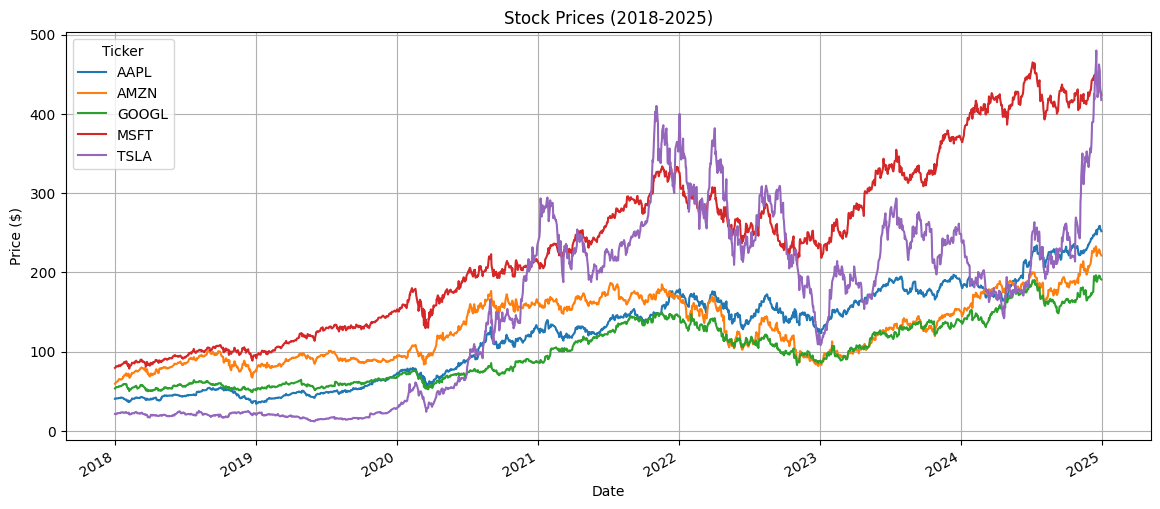

In [43]:
data.plot(figsize=(14,6))
plt.title("Stock Prices (2018-2025)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()


# Calculating and Visualizing Returns

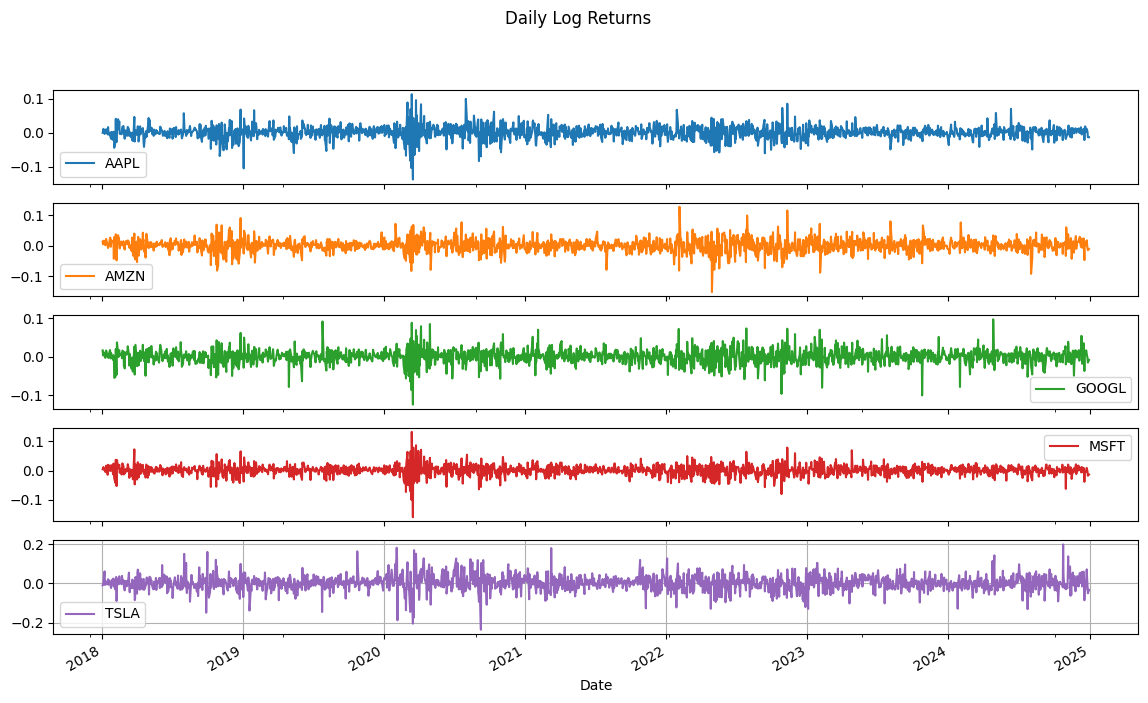

In [27]:
returns = np.log(data / data.shift(1)).dropna()

returns.plot(figsize=(14,8), subplots=True, title="Daily Log Returns")
plt.grid(True)
plt.show()


# Volatility Analysis (Rolling Standard Deviation)

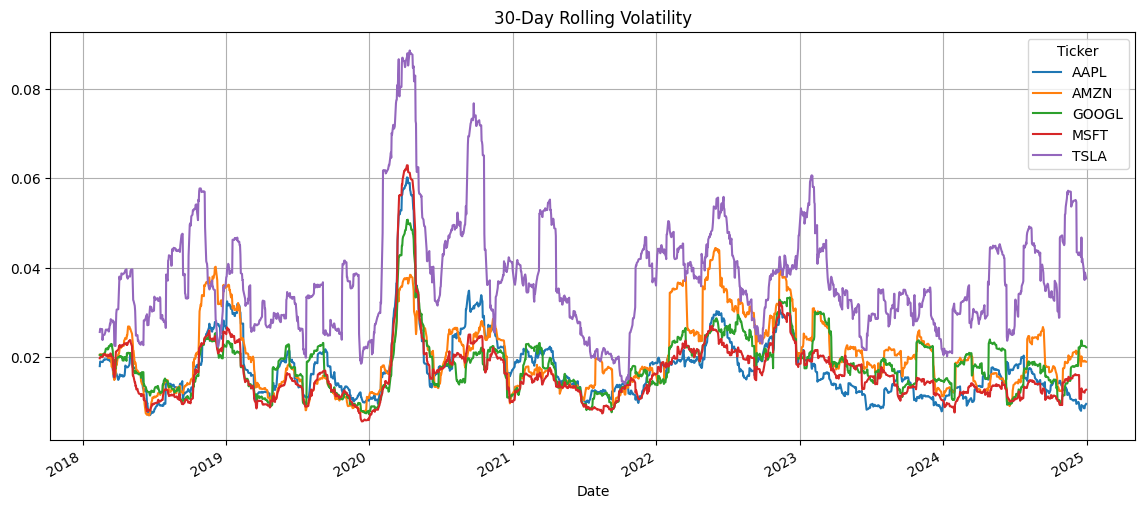

In [29]:
rolling_vol = returns.rolling(window=30).std()

rolling_vol.plot(figsize=(14,6))
plt.title("30-Day Rolling Volatility")
plt.grid(True)
plt.show()


# Correlation Analysis Between Assets

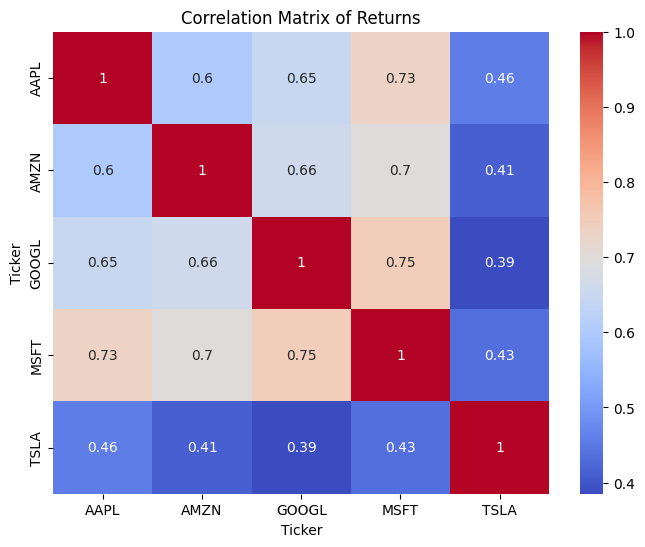

In [31]:
corr = returns.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Returns")
plt.show()


# Time-Series Decomposition (for one stock)

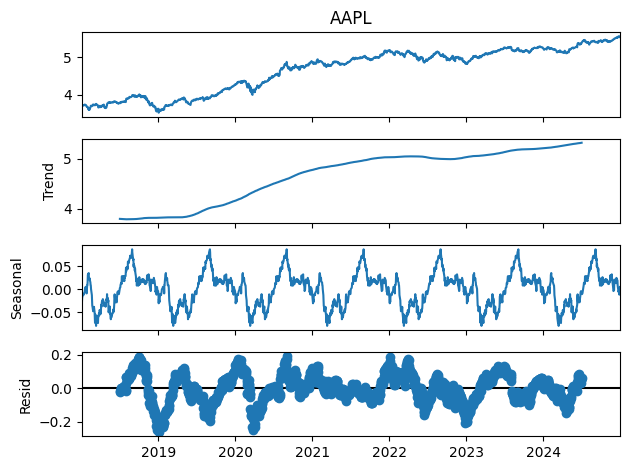

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Log-transform AAPL prices
log_aapl = np.log(data['AAPL'])

# Decompose with annual seasonality assumption (252 trading days)
result = seasonal_decompose(log_aapl, model='additive', period=252)
result.plot()
plt.tight_layout()
plt.show()


# Anomaly Detection with Z-Score on Residuals

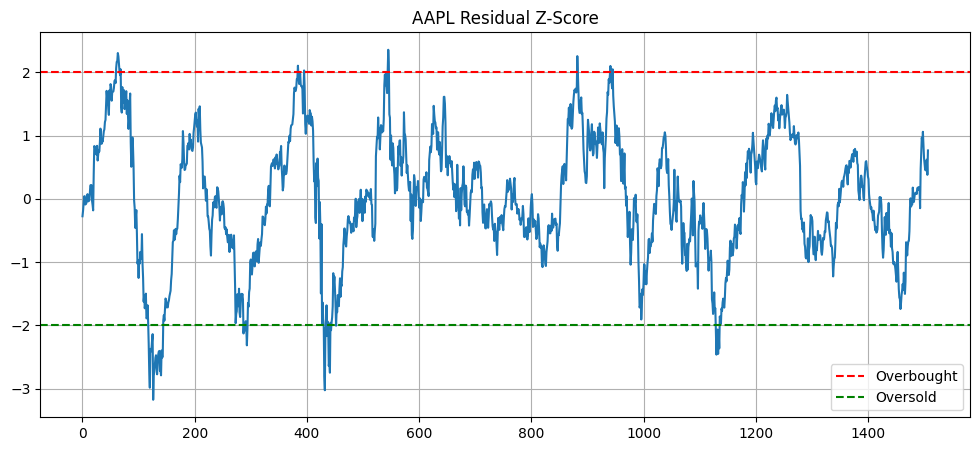

In [35]:
from scipy.stats import zscore

residuals = result.resid.dropna()
z_resid = zscore(residuals)

plt.figure(figsize=(12,5))
plt.plot(z_resid)
plt.axhline(2, color='red', linestyle='--', label='Overbought')
plt.axhline(-2, color='green', linestyle='--', label='Oversold')
plt.legend()
plt.title("AAPL Residual Z-Score")
plt.grid(True)
plt.show()


# Full Backtest Skeleton

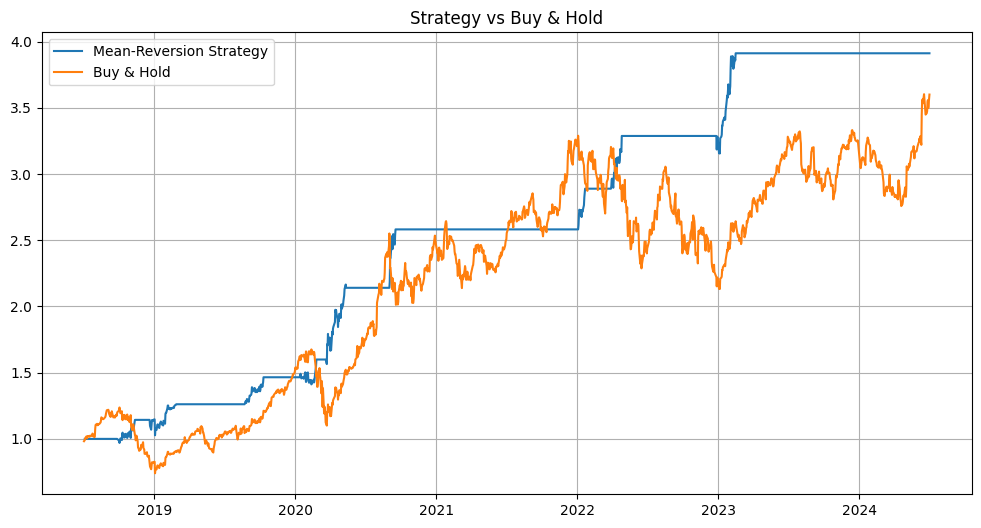

In [52]:
from scipy.stats import zscore

# Step 1: Make sure z_resid is a pandas Series.
z_resid = pd.Series(zscore(residuals.dropna()), index=residuals.dropna().index)

# Step 2: Create signal based on Z-score
signal = pd.Series(0, index=z_resid.index)
signal[z_resid < -2] = 1   # Long Signal
signal[z_resid > 2] = -1   # Short Signal

# Step 3: Create position (hold until z-score returns to 0)
position = signal.copy()
for i in range(1, len(position)):
    if position.iloc[i] == 0:
        position.iloc[i] = position.iloc[i-1] if abs(z_resid.iloc[i]) > 0.5 else 0

# Step 4: Calculate returns
aapl_returns = returns['AAPL'].loc[position.index]
strategy_returns = position.shift(1) * aapl_returns  # Shift to avoid look-ahead bias

# Step 5: Cumulative returns
cumulative_strategy_returns = (1 + strategy_returns).cumprod()
cumulative_buy_hold = (1 + aapl_returns).cumprod()

# Step 6: Plot results
plt.figure(figsize=(12,6))
plt.plot(cumulative_strategy_returns, label='Mean-Reversion Strategy')
plt.plot(cumulative_buy_hold, label='Buy & Hold')
plt.legend()
plt.title('Strategy vs Buy & Hold')
plt.grid(True)
plt.show()


# Strategy Evaluation Metrics

In [39]:
# Strategy performance metrics
print("Cumulative Strategy Return:", cumulative_strategy_returns.iloc[-1] - 1)
print("Cumulative Buy & Hold Return:", cumulative_buy_hold.iloc[-1] - 1)
print("Annualized Volatility (Strategy):", strategy_returns.std() * np.sqrt(252))
print("Annualized Volatility (Buy & Hold):", aapl_returns.std() * np.sqrt(252))
print("Strategy Sharpe Ratio:", strategy_returns.mean() / strategy_returns.std() * np.sqrt(252))


Cumulative Strategy Return: 2.911754706014836
Cumulative Buy & Hold Return: 2.5999766646669165
Annualized Volatility (Strategy): 0.15264708339233332
Annualized Volatility (Buy & Hold): 0.3173440032194247
Strategy Sharpe Ratio: 1.5702168649075914
